In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from skopt import BayesSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, make_scorer, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df_fam_featured = pd.read_csv('../Data_modelo/df_modelo_balanceado.csv')

In [3]:
df_fam_featured = df_fam_featured.rename(columns={'pct_deficientes':'pct_pcd'})

In [4]:
df_fam_featured = df_fam_featured.drop('id_familia', axis=1)

In [5]:
df_fam_featured.columns

Index(['uf_ibge', 'classf', 'cod_local_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam',
       'cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
       'ind_parc_mds_fam', 'qtde_pessoas', 'dias_cadastramento',
       'dias_atualizacao', 'classe_renda', 'rf_idade', 'rf_trab_principal',
       'rf_com_deficiencia', 'rf_trab_agricultura', 'rf_sexo',
       'rf_curso_frequentou', 'rf_curso_frequenta', 'rf_trabalhou_semana',
       'rf_cor_raca', 'rf_concluiu_curso', 'pct_extrativista',
       'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_e

In [6]:
df_fam_featured.head()

,uf_ibge,classf,cod_local_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_iluminacao_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,qtde_pessoas,...,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_pcd,pct_1_infancia,pct_adulto,pct_crianca_adolescente,fam_gpte,ideb_2017_municipio
0,15,1,1.0,2.0,2.0,1.0,2.0,2.0,0.0,3,...,0.333333,0.0,0.0,0.0,0.000,0.000000,0.333333,0.666667,0.0,4.8
1,13,3,1.0,4.0,2.0,1.0,2.0,2.0,0.0,8,...,0.000000,0.0,0.0,0.0,0.375,0.375000,0.250000,0.375000,0.0,4.6
2,29,3,2.0,4.0,2.0,1.0,2.0,2.0,205.0,2,...,0.000000,0.5,0.0,0.0,0.000,0.000000,0.500000,0.500000,1.0,4.0
3,28,3,2.0,5.0,2.0,1.0,2.0,2.0,0.0,2,...,0.000000,0.0,0.0,0.0,0.000,0.500000,0.500000,0.000000,0.0,4.2
4,33,3,1.0,5.0,5.0,1.0,2.0,2.0,0.0,3,...,0.000000,0.0,0.0,0.0,0.000,0.333333,0.666667,0.000000,0.0,4.6


In [7]:
corr_matrix = df_fam_featured.corr()

In [8]:
mask_fam = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

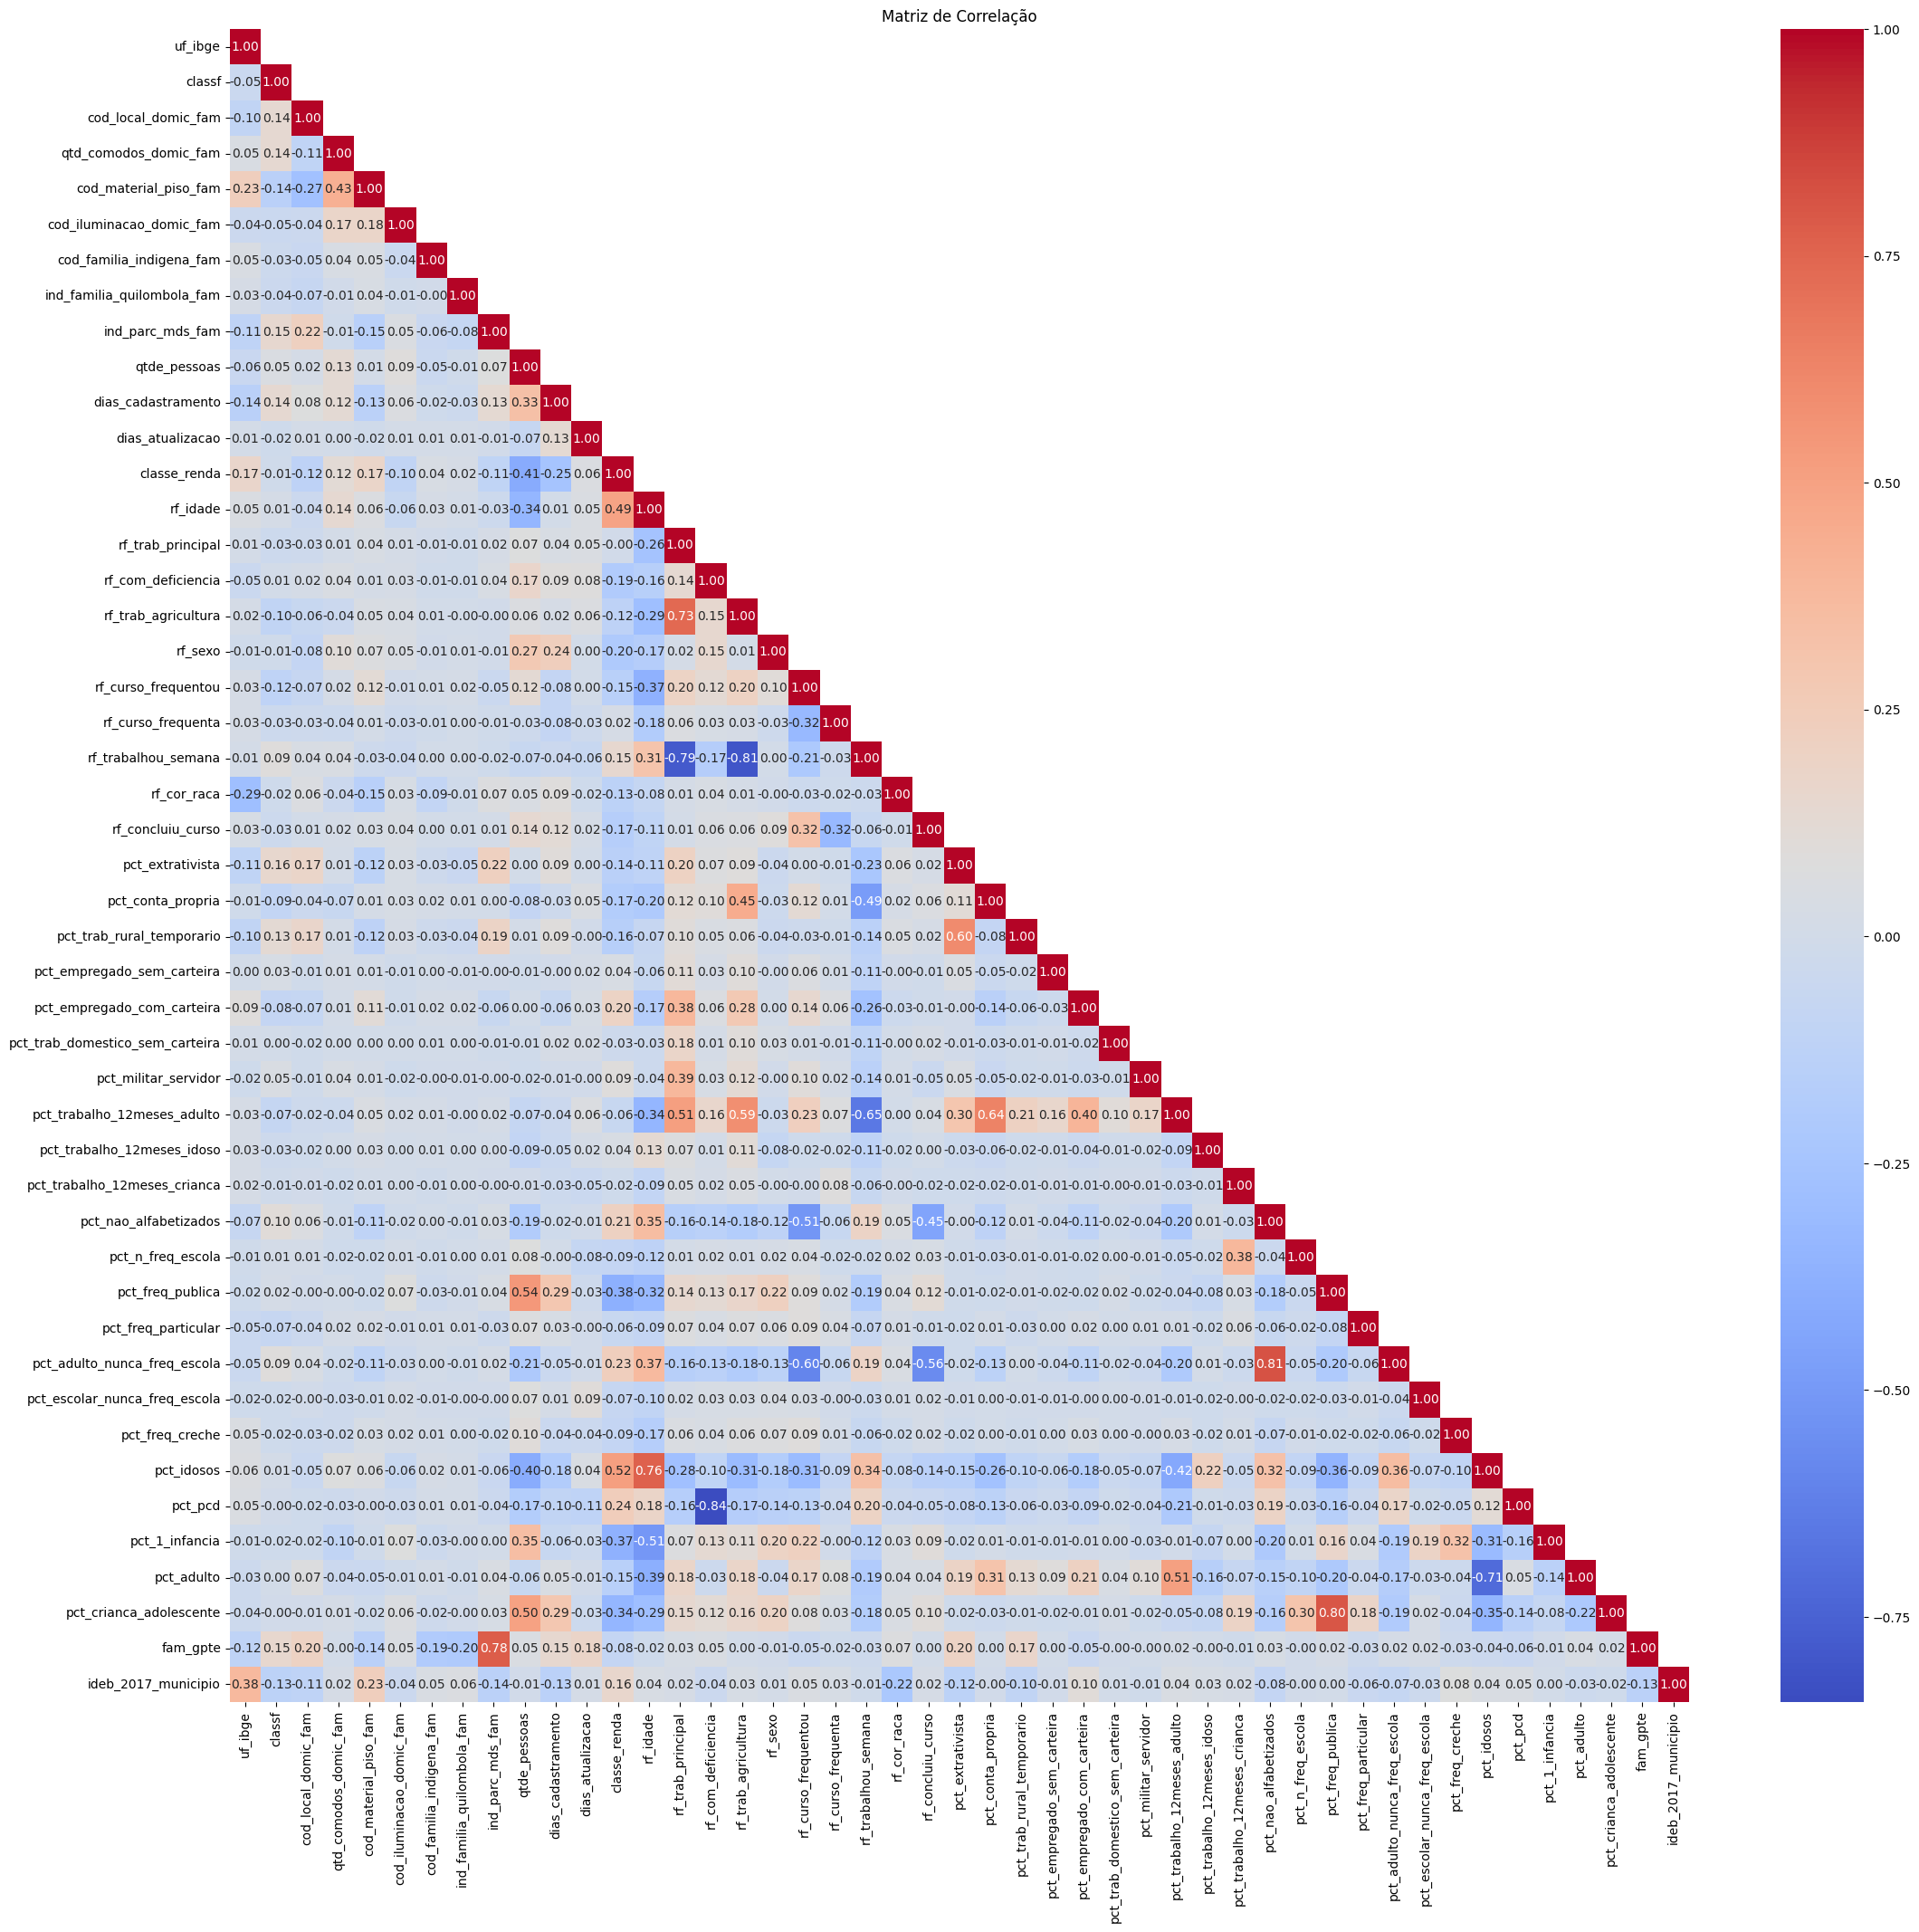

In [9]:
# Verificar a correlação entre as variáveis
plt.figure(figsize=(26, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask_fam)
plt.title('Matriz de Correlação')
plt.show()

In [10]:
# Função para verificar se há correlação acima de 0.8
def alta_corr():
    corr_threshold = 0.8
    high_corr_pairs = []

    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[1]):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                var1 = corr_matrix.index[i]
                var2 = corr_matrix.columns[j]
                correlation = corr_matrix.iloc[i, j]
                high_corr_pairs.append((var1, var2, correlation))

    # Verificar se há pares com correlação alta
    if high_corr_pairs:
        # Mostrar os pares de variáveis com correlação acima de 0.8
        for var1, var2, correlation in high_corr_pairs:
            print(f'Variáveis: {var1} e {var2} - Correlação: {correlation:.2f}')
    else:
        # Caso não haja correlação acima do threshold, exibir aviso
        print('Nenhum par de variáveis com correlação acima de 0.8 foi encontrado.')

In [11]:
alta_corr()

Variáveis: rf_com_deficiencia e pct_pcd - Correlação: -0.84
Variáveis: rf_trab_agricultura e rf_trabalhou_semana - Correlação: -0.81
Variáveis: pct_nao_alfabetizados e pct_adulto_nunca_freq_escola - Correlação: 0.81


In [12]:
# Retirar as variáveis com correlação acima de 0.8
df_fam_featured = df_fam_featured.drop(['rf_com_deficiencia', 'pct_nao_alfabetizados', 'rf_trabalhou_semana'], axis=1)

In [13]:
corr_matrix = df_fam_featured.corr()

In [14]:
alta_corr()

Nenhum par de variáveis com correlação acima de 0.8 foi encontrado.


In [15]:
X = df_fam_featured.drop('classe_renda', axis=1)
y = df_fam_featured['classe_renda']

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96791 entries, 0 to 96790
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   uf_ibge                          96791 non-null  int64  
 1   classf                           96791 non-null  int64  
 2   cod_local_domic_fam              96791 non-null  float64
 3   qtd_comodos_domic_fam            96791 non-null  float64
 4   cod_material_piso_fam            96791 non-null  float64
 5   cod_iluminacao_domic_fam         96791 non-null  float64
 6   cod_familia_indigena_fam         96791 non-null  float64
 7   ind_familia_quilombola_fam       96791 non-null  float64
 8   ind_parc_mds_fam                 96791 non-null  float64
 9   qtde_pessoas                     96791 non-null  int64  
 10  dias_cadastramento               96791 non-null  float64
 11  dias_atualizacao                 96791 non-null  int64  
 12  rf_idade          

In [17]:
min_values = df_fam_featured.min()
max_values = df_fam_featured.max()

# Criar um dataframe para exibir o mínimo e o máximo lado a lado de cada coluna
min_max_df = pd.DataFrame({'Min': min_values, 'Max': max_values})

min_max_df

,Min,Max
uf_ibge,11.0,53.000000
classf,1.0,3.000000
cod_local_domic_fam,1.0,9.000000
qtd_comodos_domic_fam,-1.0,20.000000
cod_material_piso_fam,-1.0,7.000000
cod_iluminacao_domic_fam,-1.0,6.000000
cod_familia_indigena_fam,1.0,2.000000
ind_familia_quilombola_fam,1.0,2.000000
ind_parc_mds_fam,0.0,306.000000
qtde_pessoas,1.0,13.000000


In [18]:
X.columns

Index(['uf_ibge', 'classf', 'cod_local_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam',
       'cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
       'ind_parc_mds_fam', 'qtde_pessoas', 'dias_cadastramento',
       'dias_atualizacao', 'rf_idade', 'rf_trab_principal',
       'rf_trab_agricultura', 'rf_sexo', 'rf_curso_frequentou',
       'rf_curso_frequenta', 'rf_cor_raca', 'rf_concluiu_curso',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_n_freq_escola', 'pct_freq_publica',
       'pct_freq_particular', 'pct_adulto_nunca_freq_escola',
       'pct_escolar_nunca_freq_escola', 'pct_freq_creche', 'pct_idosos',
       'pct_pcd', 'pct_1_infancia', 'pct_adulto', 'p

In [19]:
# Criar funções para transformar colunas categóricas e deixar o -1 inalterado
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        # Fazer o fit nas colunas, mas ignorando os valores -1
        self.scaler_dict = {}
        for col in X.columns:
            mask = X[col] != -1
            if mask.any():  # Verificar se há valores diferentes de -1
                self.scaler_dict[col] = self.scaler.fit(X[col][mask].values.reshape(-1, 1))
        return self

    def transform(self, X):
        # Aplicar a transformação para cada coluna, mantendo -1 inalterado
        X_scaled = X.copy()
        for col in X.columns:
            mask = X[col] != -1
            if col in self.scaler_dict:
                # Converter a coluna para float antes de aplicar a transformação
                X_scaled[col] = X_scaled[col].astype(float)
                X_scaled.loc[mask, col] = self.scaler_dict[col].transform(X[col][mask].values.reshape(-1, 1)).flatten()
        return X_scaled

In [20]:
# Identificar colunas categóricas para One-Hot Encoding
categorical_columns = ['uf_ibge', 'classf', 'cod_local_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam',
       'cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
       'ind_parc_mds_fam', 'rf_trab_principal',
       'rf_trab_agricultura', 'rf_sexo', 'rf_curso_frequentou',
       'rf_curso_frequenta', 'rf_cor_raca', 'rf_concluiu_curso',
       'fam_gpte']

numeric_columns = [col for col in X.columns if col not in categorical_columns]

In [21]:
# Pipeline de pré-processamento com OneHotEncoder para categóricas e CustomScaler para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', CustomScaler(scaler=StandardScaler()), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

In [22]:
# Definir os modelos
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [23]:
# Configurar a busca Bayesiana para os hiperparâmetros
search_spaces = {
    'RandomForest': {
        'n_estimators': (10, 200),
        'max_depth': (1, 20),
        'min_samples_split': (2, 10)
    },
    'XGBoost': {
        'n_estimators': (50, 300),
        'learning_rate': (0.01, 0.2, 'log-uniform'),
        'max_depth': (3, 10)
    },
    'CatBoost': {
        'depth': (4, 10),
        'learning_rate': (0.01, 0.2, 'log-uniform'),
        'iterations': (100, 300)
    }
}

In [24]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Pipeline de pré-processamento
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar o pipeline de pré-processamento
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [26]:
def plot_confusion_matrix(y_true, y_pred, title, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizar por linha (true labels)
        fmt = '.2%'  # Formatar como porcentagem
    else:
        fmt = 'd'  # Formatar como números inteiros

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=False)
    plt.title(f"Matriz de Confusão - {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Treinando RandomForest...
Melhores hiperparâmetros para RandomForest: OrderedDict([('max_depth', 19), ('min_samples_split', 8), ('n_estimators', 176)])
Avaliando RandomForest...
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      6371
           1       0.69      0.65      0.67      6527
           2       0.80      0.79      0.79      6461

    accuracy                           0.75     19359
   macro avg       0.74      0.75      0.74     19359
weighted avg       0.74      0.75      0.74     19359



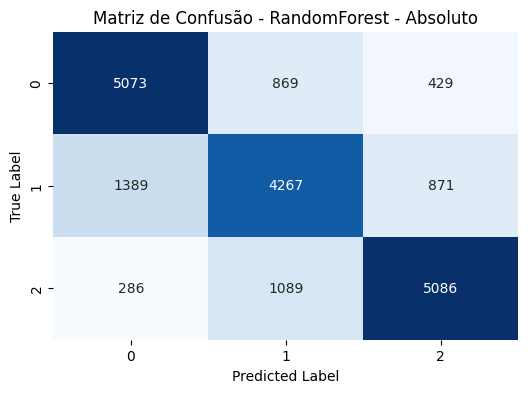

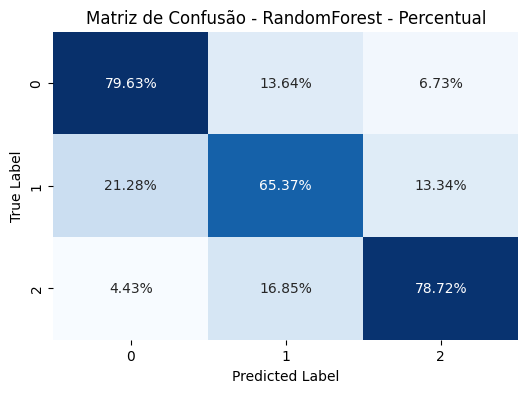

Treinando XGBoost...
Melhores hiperparâmetros para XGBoost: OrderedDict([('learning_rate', 0.12287608582119026), ('max_depth', 9), ('n_estimators', 126)])
Avaliando XGBoost...
              precision    recall  f1-score   support

           0       0.77      0.81      0.78      6371
           1       0.70      0.66      0.68      6527
           2       0.80      0.81      0.80      6461

    accuracy                           0.76     19359
   macro avg       0.75      0.76      0.75     19359
weighted avg       0.75      0.76      0.75     19359



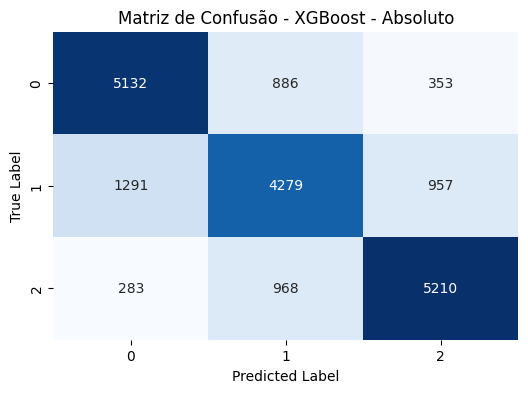

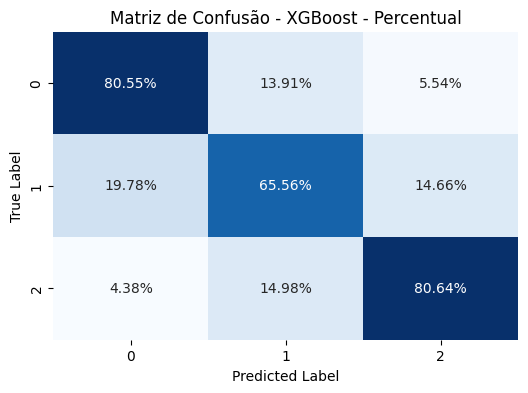

Treinando CatBoost...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros para CatBoost: OrderedDict([('depth', 6), ('iterations', 246), ('learning_rate', 0.16356457461011642)])
Avaliando CatBoost...
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      6371
           1       0.69      0.65      0.67      6527
           2       0.80      0.80      0.80      6461

    accuracy                           0.75     19359
   macro avg       0.75      0.75      0.75     19359
weighted avg       0.75      0.75      0.75     19359



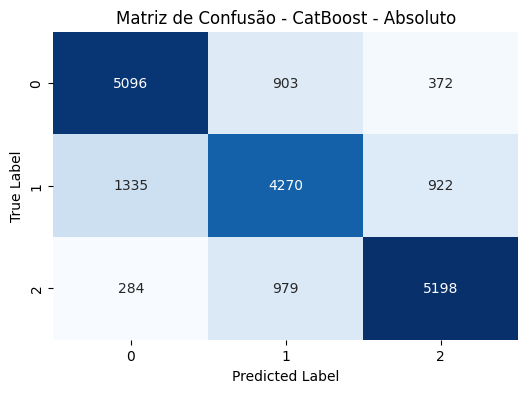

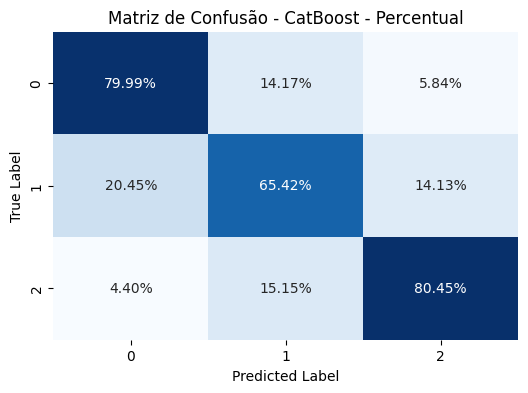

CPU times: user 1min 44s, sys: 6.77 s, total: 1min 51s
Wall time: 8min 7s


In [27]:
%%time
# Armazenar resultados
best_models = {}

for name, model in models.items():
    print(f'Treinando {name}...')
    
    # Otimização com BayesSearchCV
    opt = BayesSearchCV(model, search_spaces[name], n_iter=10, cv=3, random_state=42, n_jobs=-1)
    opt.fit(X_train_preprocessed, y_train)
    
    # Armazenar o melhor modelo
    best_models[name] = opt.best_estimator_
    print(f'Melhores hiperparâmetros para {name}: {opt.best_params_}')
    
    print(f'Avaliando {name}...')
    
    # Previsões no conjunto de teste
    y_pred = opt.predict(X_test_preprocessed)
    
    # Relatório de classificação
    print(classification_report(y_test, y_pred))
    
    # Plotar a matriz de confusão com números absolutos
    plot_confusion_matrix(y_test, y_pred, title=f'{name} - Absoluto')
    
    # Plotar a matriz de confusão com porcentagens
    plot_confusion_matrix(y_test, y_pred, title=f'{name} - Percentual', normalize=True)

In [28]:
# Função para obter os nomes das colunas após o ColumnTransformer
def get_feature_names(column_transformer):
    output_features = []
    
    for name, transformer, column in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(column)  # Colunas numéricas mantêm seus nomes
        elif name == 'cat':
            # OneHotEncoder adiciona sufixos para cada valor das variáveis categóricas
            ohe_columns = transformer.get_feature_names_out(column)
            output_features.extend(ohe_columns)
    
    return output_features

In [29]:
# Aplicar o pipeline de pré-processamento
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Obter os nomes das colunas após o pré-processamento
processed_columns = get_feature_names(preprocessor)

Mediana das importâncias para RandomForest: 0.0015395873551582839


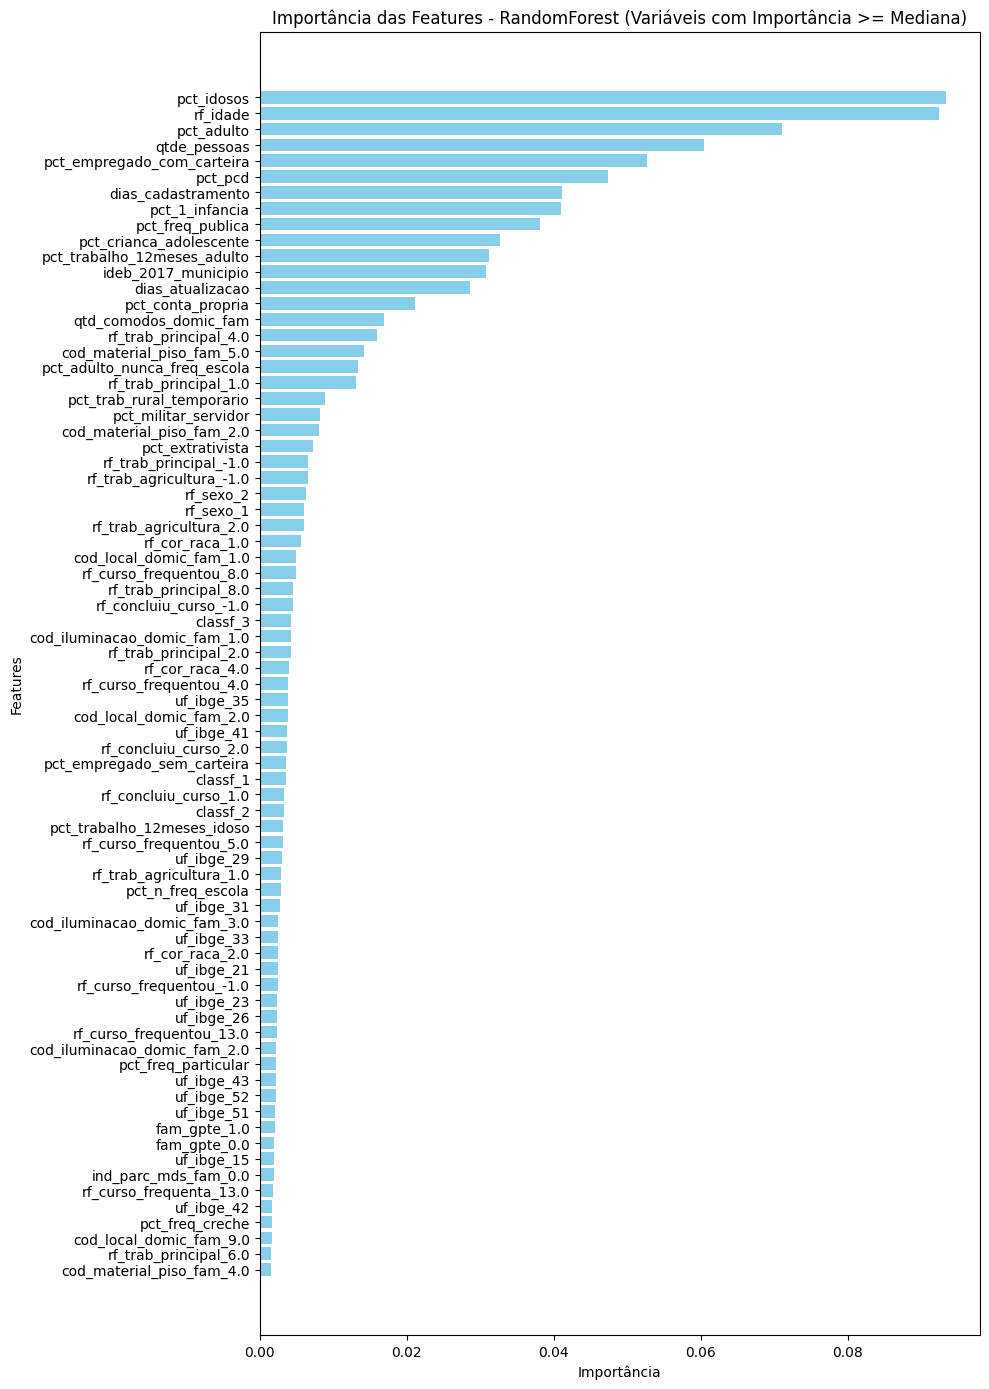

Mediana das importâncias para XGBoost: 0.003156410064548254


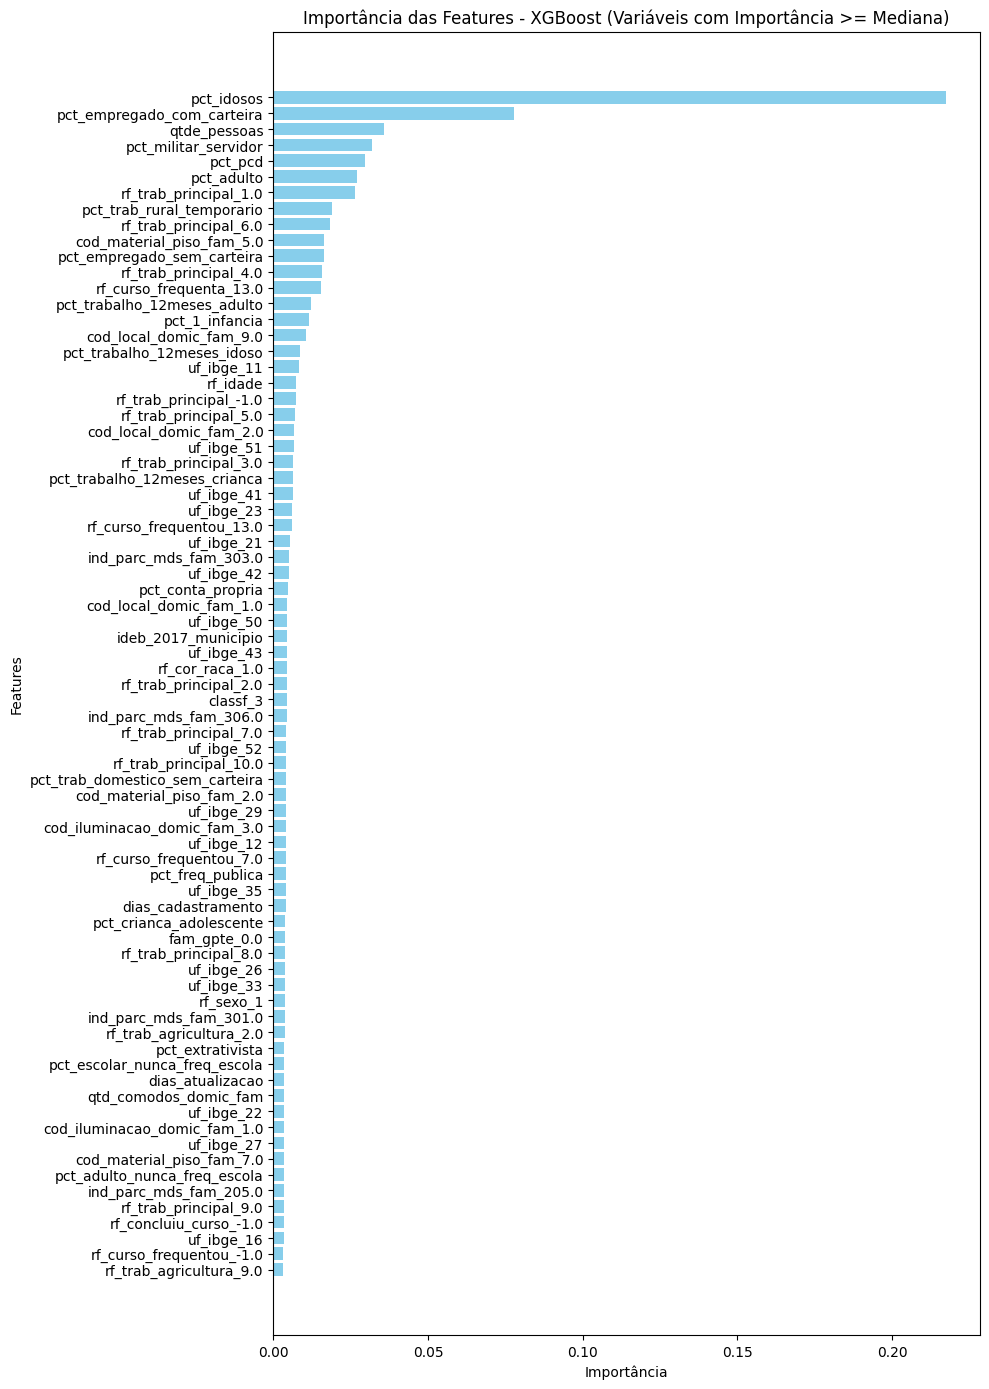

Mediana das importâncias para CatBoost: 0.05268512143982654


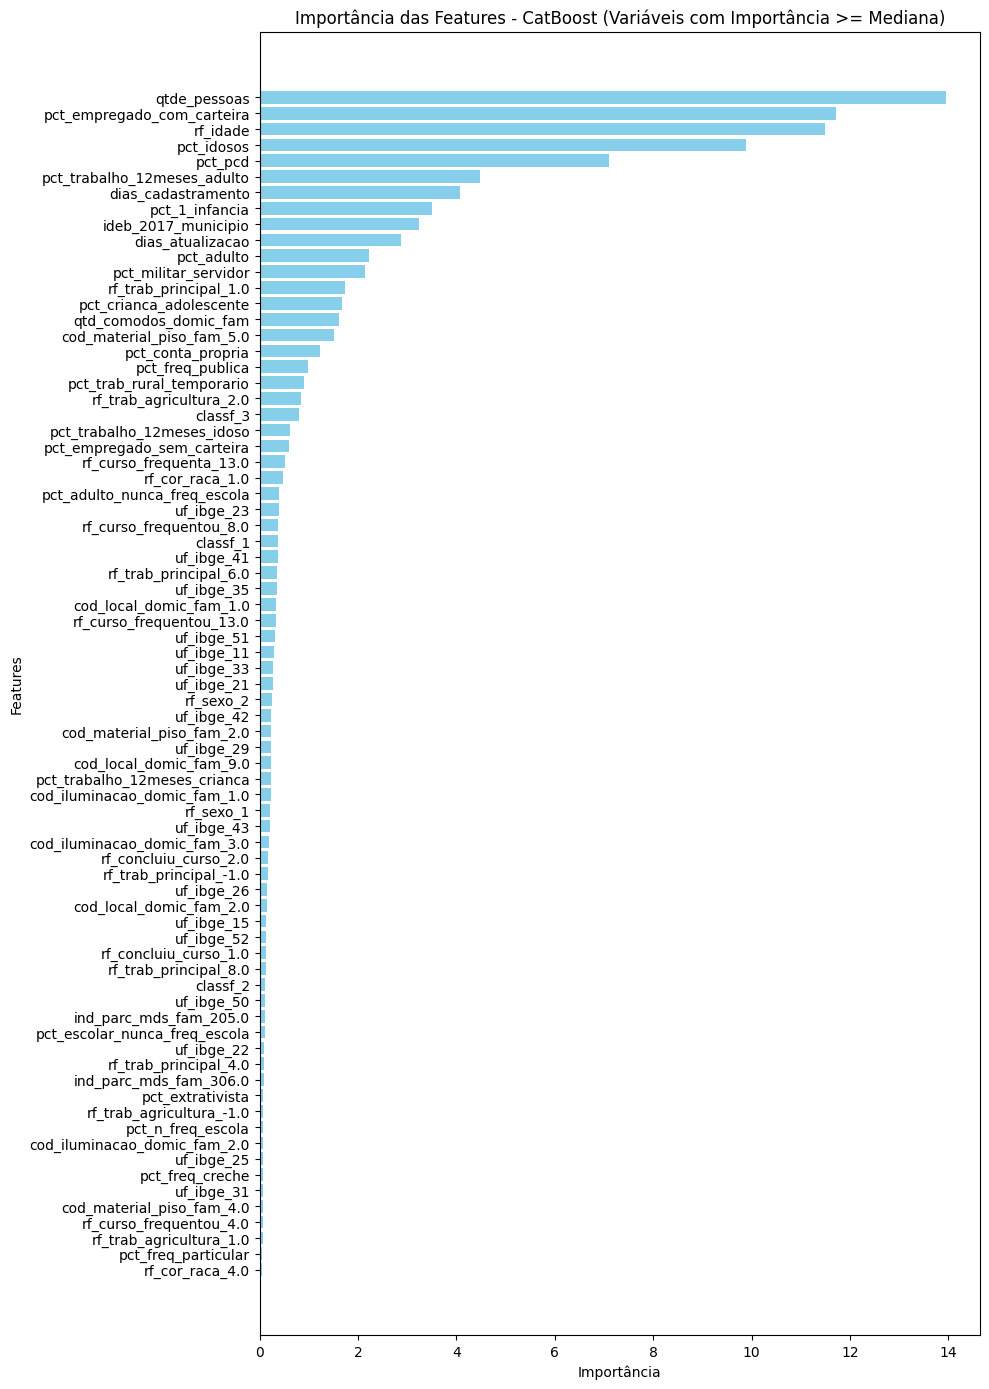

In [30]:
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        median_importance = np.median(importances)
        important_features = np.where(importances >= median_importance)[0]
        
        # Mostrar a mediana das importâncias
        print(f"Mediana das importâncias para {name}: {median_importance}")
        
        # Filtrar as variáveis acima da mediana
        filtered_importances = importances[important_features]
        filtered_columns = np.array(processed_columns)[important_features]
        
        # Ordenar as importâncias filtradas de forma decrescente
        sorted_indices = np.argsort(filtered_importances)[::-1]
        sorted_importances = filtered_importances[sorted_indices]
        sorted_columns = filtered_columns[sorted_indices]
        
        # Gráfico de barras horizontal mostrando as variáveis mais importantes
        plt.figure(figsize=(10, 14))
        plt.barh(sorted_columns, sorted_importances, color='skyblue')
        plt.title(f"Importância das Features - {name} (Variáveis com Importância >= Mediana)")
        plt.xlabel('Importância')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.gca().invert_yaxis()  # Inverter o eixo Y para a ordem decrescente
        plt.show()

## Novo treinamento diminuindo o threshold para aumentar o recall
#### O objetivo é verificar o melhor threshold para cada modelo utilizando apenas as variáveis mais importantes

In [42]:
# Considerando 3 classes: 0.0, 1.0, 2.0
n_classes = 3  # Especificando o número de classes diretamente

# Binarizar as classes para ROC multiclasses (one-vs-rest)
y_train_bin = label_binarize(y_train, classes=[0.0, 1.0, 2.0])
y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0])

In [43]:
# Função para obter a importância das variáveis acima da mediana
def get_important_features(model, X):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        median_importance = np.median(importances)
        important_features = np.where(importances >= median_importance)[0]
        
        # Filtrar as colunas importantes (se X for DataFrame)
        important_columns = X.columns[important_features] if hasattr(X, 'columns') else important_features
        print(f'Variáveis importantes para {type(model).__name__}:', important_columns)
        return important_columns
    else:
        print(f'O modelo {type(model).__name__} não possui feature_importances_')
        return []

In [44]:
# Função para plotar a curva ROC para cada classe
def plot_roc_auc_multiclass(model, X_test, y_test_bin, model_name, n_classes):
    y_prob = model.predict_proba(X_test)

    # Plotar curva ROC para cada classe
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência (aleatório)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC para {model_name} (Multiclasses)')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
# Função para otimizar o limiar manualmente
def threshold_optimization_multiclass(y_true_bin, y_prob):
    best_threshold = 0.5  # Default threshold
    best_recall = 0
    thresholds = np.linspace(0.1, 0.9, 100)

    for threshold in thresholds:
        y_pred_thresholded = (y_prob >= threshold).astype(int)
        recall = recall_score(y_true_bin, y_pred_thresholded, average='macro')
        if recall > best_recall:
            best_recall = recall
            best_threshold = threshold

    print(f"Melhor threshold encontrado: {best_threshold} com recall: {best_recall}")
    return best_threshold


### Modelo: RandomForest ###
Variáveis importantes para RandomForestClassifier: Index(['uf_ibge', 'classf', 'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequentou', 'rf_cor_raca',
       'rf_concluiu_curso', 'pct_conta_propria', 'pct_empregado_com_carteira',
       'pct_trabalho_12meses_adulto', 'pct_freq_publica', 'pct_idosos',
       'pct_pcd', 'pct_1_infancia', 'pct_adulto', 'pct_crianca_adolescente',
       'ideb_2017_municipio'],
      dtype='object')


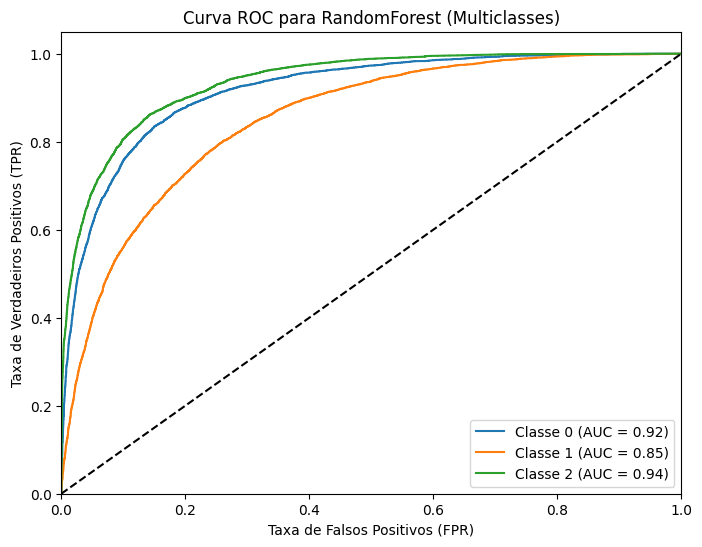

Melhor threshold encontrado: 0.1 com recall: 0.9573499962655321
Classification report para RandomForest com threshold ajustado:
              precision    recall  f1-score   support

    Classe 0       0.57      0.94      0.71      6371
    Classe 1       0.46      0.96      0.62      6527
    Classe 2       0.58      0.96      0.73      6461

   micro avg       0.53      0.96      0.68     19359
   macro avg       0.54      0.96      0.69     19359
weighted avg       0.54      0.96      0.68     19359
 samples avg       0.61      0.96      0.72     19359



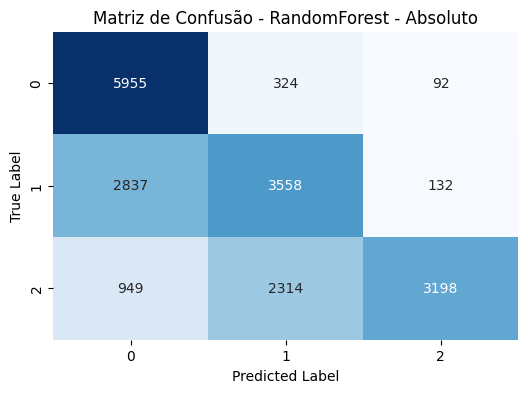

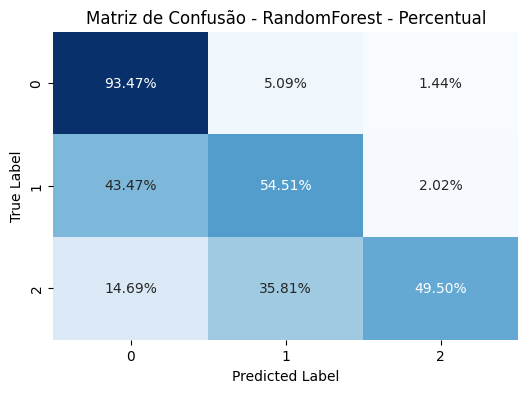


### Modelo: XGBoost ###
Variáveis importantes para XGBClassifier: Index(['uf_ibge', 'cod_local_domic_fam', 'cod_material_piso_fam',
       'cod_iluminacao_domic_fam', 'qtde_pessoas', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequenta', 'pct_conta_propria',
       'pct_trab_rural_temporario', 'pct_empregado_sem_carteira',
       'pct_empregado_com_carteira', 'pct_trab_domestico_sem_carteira',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca',
       'pct_freq_publica', 'pct_idosos', 'pct_pcd', 'pct_1_infancia',
       'pct_adulto'],
      dtype='object')


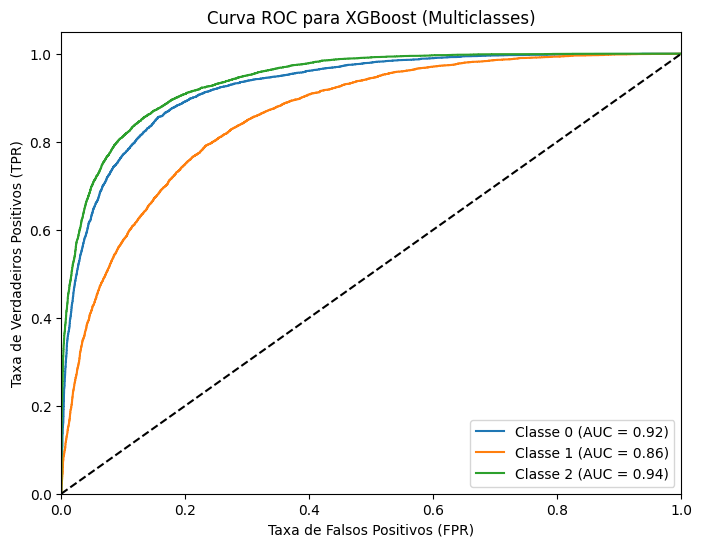

Melhor threshold encontrado: 0.1 com recall: 0.9516507775343461
Classification report para XGBoost com threshold ajustado:
              precision    recall  f1-score   support

    Classe 0       0.61      0.94      0.74      6371
    Classe 1       0.47      0.96      0.63      6527
    Classe 2       0.60      0.96      0.74      6461

   micro avg       0.55      0.95      0.70     19359
   macro avg       0.56      0.95      0.70     19359
weighted avg       0.56      0.95      0.70     19359
 samples avg       0.63      0.95      0.73     19359



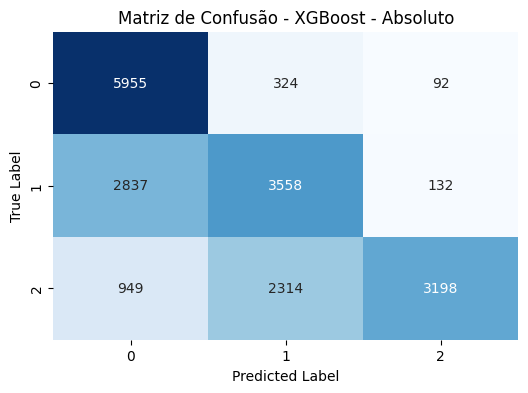

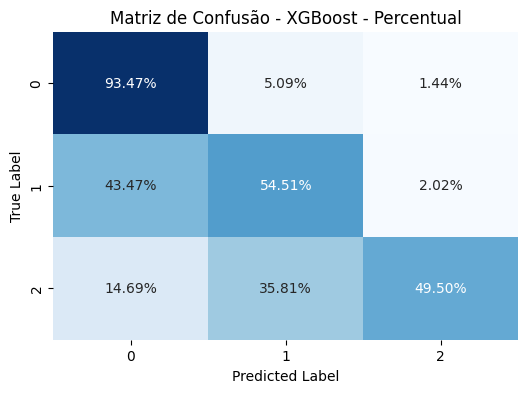


### Modelo: CatBoost ###
Variáveis importantes para CatBoostClassifier: Index(['uf_ibge', 'classf', 'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequentou', 'pct_conta_propria',
       'pct_empregado_com_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_freq_publica', 'pct_idosos', 'pct_pcd', 'pct_1_infancia',
       'pct_adulto', 'pct_crianca_adolescente', 'ideb_2017_municipio'],
      dtype='object')


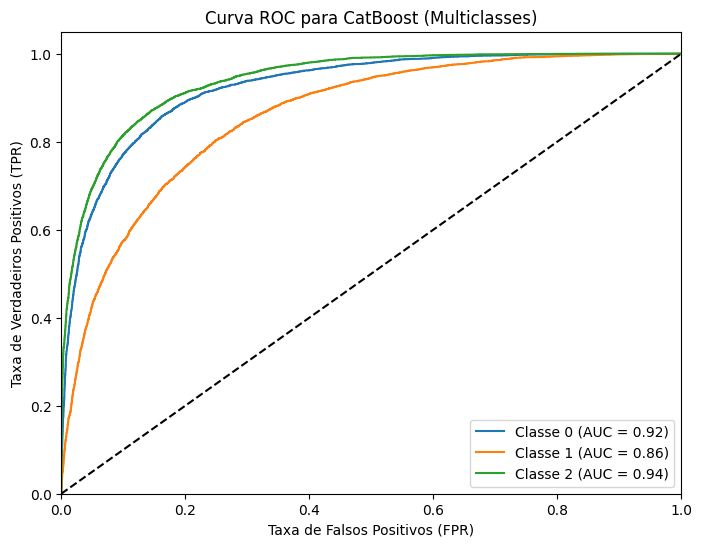

Melhor threshold encontrado: 0.1 com recall: 0.9493326234445897
Classification report para CatBoost com threshold ajustado:
              precision    recall  f1-score   support

    Classe 0       0.61      0.93      0.74      6371
    Classe 1       0.47      0.96      0.63      6527
    Classe 2       0.61      0.96      0.75      6461

   micro avg       0.56      0.95      0.70     19359
   macro avg       0.56      0.95      0.71     19359
weighted avg       0.56      0.95      0.70     19359
 samples avg       0.64      0.95      0.73     19359



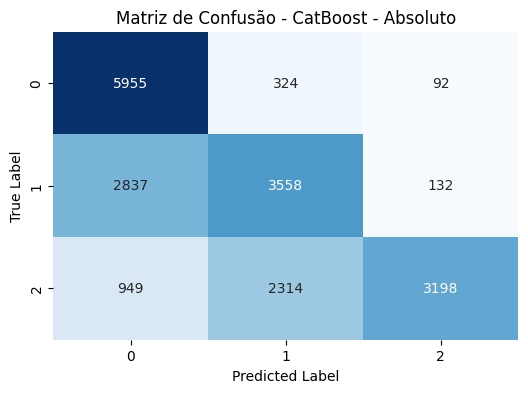

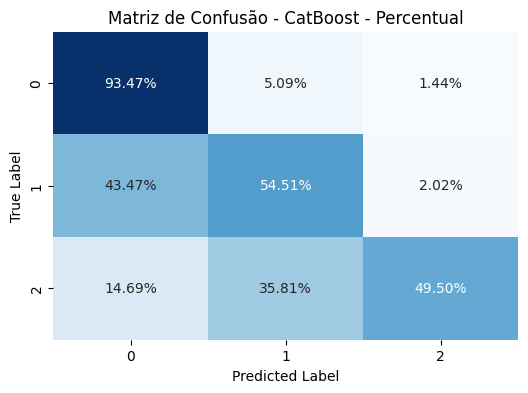

In [46]:
# Função principal para treinar e avaliar os modelos
for model_name, model in models.items():
    print(f"\n### Modelo: {model_name} ###")

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Obter variáveis importantes
    if hasattr(model, 'feature_importances_'):
        important_columns = get_important_features(model, X_train)

    # Calibrar o modelo para obter probabilidades mais confiáveis
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
    calibrated_model.fit(X_train, y_train)

    # Plotar a curva ROC para cada classe e calcular AUC
    plot_roc_auc_multiclass(calibrated_model, X_test, y_test_bin, model_name, n_classes)

    # Obter as probabilidades preditas
    y_prob = calibrated_model.predict_proba(X_test)

    # Buscar o melhor threshold manualmente
    best_threshold = threshold_optimization_multiclass(y_test_bin, y_prob)

    # Fazer previsões com o melhor threshold encontrado
    y_pred_thresholded = (y_prob >= best_threshold).astype(int)

    # Gerar o classification report (multiclasses)
    report = classification_report(y_test_bin, y_pred_thresholded, target_names=[f'Classe {i}' for i in range(n_classes)])
    print(f"Classification report para {model_name} com threshold ajustado:\n{report}")
    
    # Plotar a matriz de confusão com números absolutos
    plot_confusion_matrix(y_true_labels, y_pred_labels, f'{model_name} - Absoluto')

    # Plotar a matriz de confusão com porcentagens
    plot_confusion_matrix(y_true_labels, y_pred_labels, f'{model_name} - Percentual', normalize=True)

## Novo treinamento a partir de uma otimização de threshold
#### A ideia é que haja um balanceamento entre o recall e o f1 score, para isso, o threshold não será o menor possível

In [31]:
# Considerando 3 classes: 0.0, 1.0, 2.0
n_classes = 3

# Binarizar as classes para ROC multiclasses (one-vs-rest)
y_train_bin = label_binarize(y_train, classes=[0.0, 1.0, 2.0])
y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0])

In [32]:
# Função para obter a importância das variáveis acima da mediana
def get_important_features(model, X):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        median_importance = np.median(importances)
        important_features = np.where(importances >= median_importance)[0]
        
        # Filtrar as colunas importantes (se X for DataFrame)
        important_columns = X.columns[important_features] if hasattr(X, 'columns') else important_features
        print(f'Variáveis importantes para {type(model).__name__}:', important_columns)
        return important_columns
    else:
        print(f'O modelo {type(model).__name__} não possui feature_importances_')
        return []

In [33]:
# Função para plotar a curva ROC para cada classe
def plot_roc_auc_multiclass(model, X_test, y_test_bin, model_name, n_classes):
    y_prob = model.predict_proba(X_test)

    # Plotar curva ROC para cada classe
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência (aleatório)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC para {model_name} (Multiclasses)')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
def threshold_optimization_multiclass(y_true_bin, y_prob, recall_weight=0.7):
    best_threshold = 0.5  # Default threshold
    best_score = 0
    thresholds = np.linspace(0.1, 0.9, 100)

    for threshold in thresholds:
        y_pred_thresholded = (y_prob >= threshold).astype(int)
        
        recall = recall_score(y_true_bin, y_pred_thresholded, average='macro')
        f1 = f1_score(y_true_bin, y_pred_thresholded, average='weighted')  # F1 ponderado

        # Nova métrica ponderada que equilibra recall e F1-score
        score = recall_weight * recall + (1 - recall_weight) * f1

        # Atualizar se a nova pontuação for melhor
        if score > best_score:
            best_score = score
            best_threshold = threshold

    print(f"Melhor threshold encontrado: {best_threshold} com pontuação ponderada: {best_score}")
    return best_threshold


### Modelo: RandomForest ###
Variáveis importantes para RandomForestClassifier: Index(['uf_ibge', 'classf', 'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequentou', 'rf_cor_raca',
       'rf_concluiu_curso', 'pct_conta_propria', 'pct_empregado_com_carteira',
       'pct_trabalho_12meses_adulto', 'pct_freq_publica', 'pct_idosos',
       'pct_pcd', 'pct_1_infancia', 'pct_adulto', 'pct_crianca_adolescente',
       'ideb_2017_municipio'],
      dtype='object')


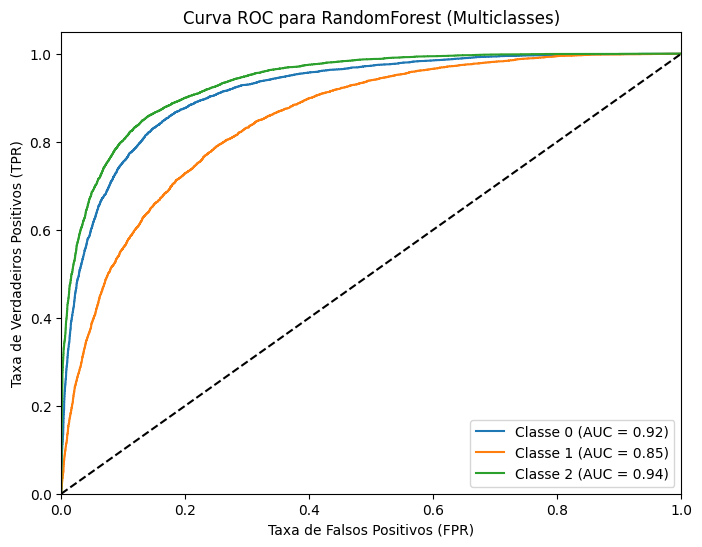

Melhor threshold encontrado: 0.1 com pontuação ponderada: 0.875798637945798
Classification report para RandomForest com threshold ajustado:
              precision    recall  f1-score   support

    Classe 0       0.57      0.95      0.71      6371
    Classe 1       0.55      0.47      0.51      6527
    Classe 2       0.94      0.47      0.62      6461

    accuracy                           0.63     19359
   macro avg       0.69      0.63      0.61     19359
weighted avg       0.69      0.63      0.61     19359



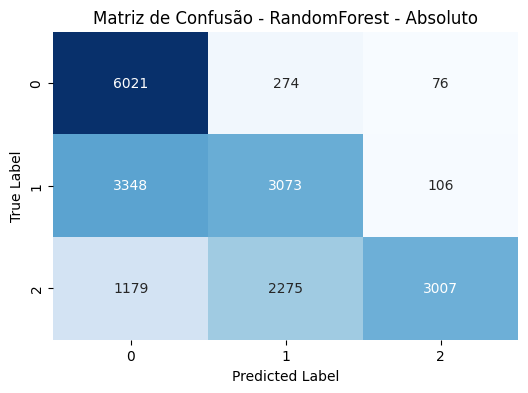

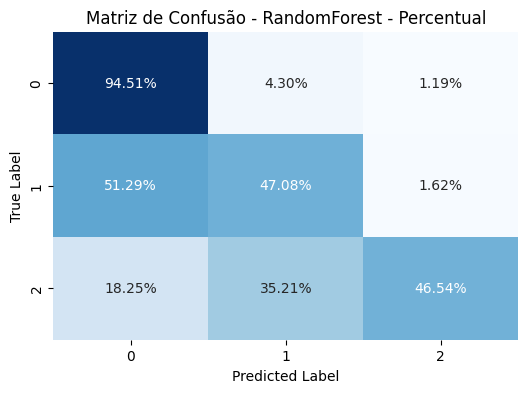


### Modelo: XGBoost ###
Variáveis importantes para XGBClassifier: Index(['uf_ibge', 'cod_local_domic_fam', 'cod_material_piso_fam',
       'cod_iluminacao_domic_fam', 'qtde_pessoas', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequenta', 'pct_conta_propria',
       'pct_trab_rural_temporario', 'pct_empregado_sem_carteira',
       'pct_empregado_com_carteira', 'pct_trab_domestico_sem_carteira',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca',
       'pct_freq_publica', 'pct_idosos', 'pct_pcd', 'pct_1_infancia',
       'pct_adulto'],
      dtype='object')


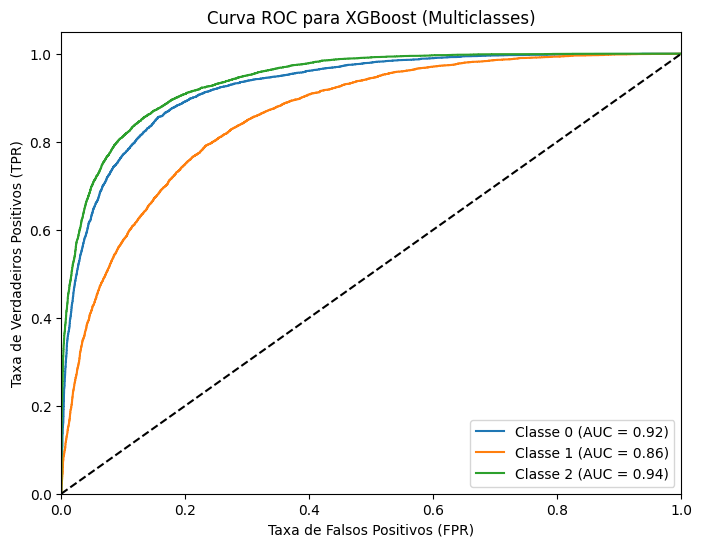

Melhor threshold encontrado: 0.1 com pontuação ponderada: 0.8766128446229015
Classification report para XGBoost com threshold ajustado:
              precision    recall  f1-score   support

    Classe 0       0.61      0.94      0.74      6371
    Classe 1       0.57      0.54      0.56      6527
    Classe 2       0.94      0.48      0.64      6461

    accuracy                           0.65     19359
   macro avg       0.71      0.65      0.64     19359
weighted avg       0.71      0.65      0.64     19359



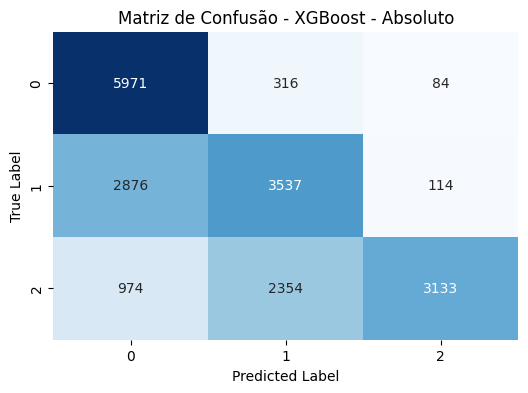

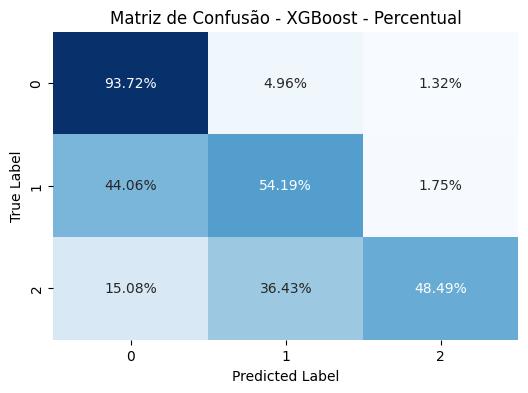


### Modelo: CatBoost ###
Variáveis importantes para CatBoostClassifier: Index(['uf_ibge', 'classf', 'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequentou', 'pct_conta_propria',
       'pct_empregado_com_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_freq_publica', 'pct_idosos', 'pct_pcd', 'pct_1_infancia',
       'pct_adulto', 'pct_crianca_adolescente', 'ideb_2017_municipio'],
      dtype='object')


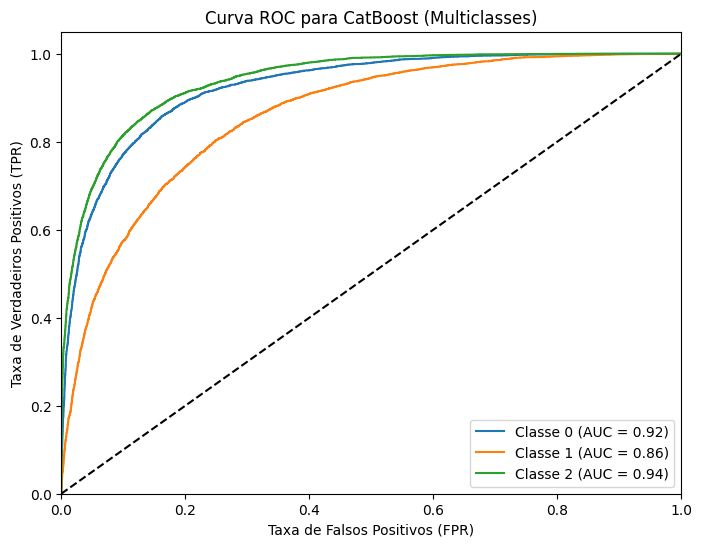

Melhor threshold encontrado: 0.1 com pontuação ponderada: 0.8760213097303483
Classification report para CatBoost com threshold ajustado:
              precision    recall  f1-score   support

    Classe 0       0.61      0.93      0.74      6371
    Classe 1       0.57      0.55      0.56      6527
    Classe 2       0.93      0.49      0.65      6461

    accuracy                           0.66     19359
   macro avg       0.71      0.66      0.65     19359
weighted avg       0.71      0.66      0.65     19359



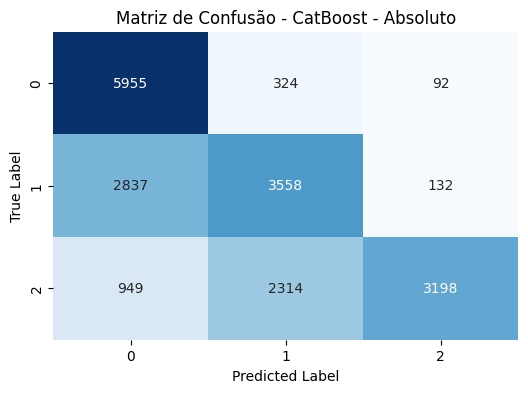

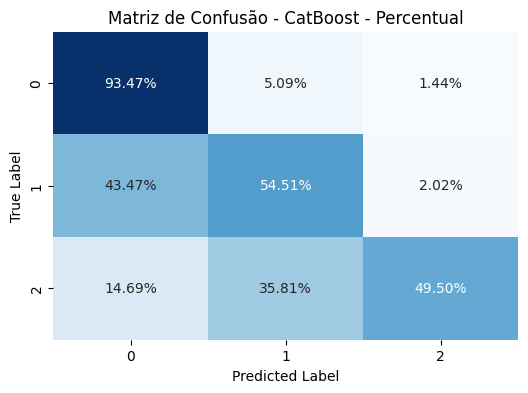

In [41]:
# Função principal para treinar e avaliar os modelos
for model_name, model in models.items():
    print(f"\n### Modelo: {model_name} ###")

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Obter variáveis importantes
    if hasattr(model, 'feature_importances_'):
        important_columns = get_important_features(model, X_train)

    # Calibrar o modelo para obter probabilidades mais confiáveis
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
    calibrated_model.fit(X_train, y_train)

    # Plotar a curva ROC para cada classe e calcular AUC
    plot_roc_auc_multiclass(calibrated_model, X_test, y_test_bin, model_name, n_classes)

    # Obter as probabilidades preditas
    y_prob = calibrated_model.predict_proba(X_test)

    # Buscar o melhor threshold balanceando recall e F1-score ponderado
    best_threshold = threshold_optimization_multiclass(y_test_bin, y_prob, recall_weight=0.7)

    # Fazer previsões com o melhor threshold encontrado
    y_pred_thresholded = (y_prob >= best_threshold).astype(int)

    # Converter rótulos binarizados de volta para rótulos originais para a matriz de confusão
    y_true_labels = y_test_bin.argmax(axis=1)
    y_pred_labels = y_pred_thresholded.argmax(axis=1)

    # Gerar o classification report (multiclasses)
    report = classification_report(y_true_labels, y_pred_labels, target_names=[f'Classe {i}' for i in range(n_classes)])
    print(f"Classification report para {model_name} com threshold ajustado:\n{report}")

    # Plotar a matriz de confusão com números absolutos
    plot_confusion_matrix(y_true_labels, y_pred_labels, f'{model_name} - Absoluto')

    # Plotar a matriz de confusão com porcentagens
    plot_confusion_matrix(y_true_labels, y_pred_labels, f'{model_name} - Percentual', normalize=True)